Predict climate of a country (use all stations beginning with country code)

Get data for all given stations
Find monthly means
Plot these

In [1]:
import json
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-16 13:59:57.496974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 13:59:57.865044: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 13:59:57.928562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 13:59:57.928585: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
f = open('data/stat_counts_tmax.txt')
data = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [k for k, v in data.items() if v == 0]
station = no_gaps_tmax[0]
print(station)

GM000010147


In [3]:
ghn = GHCND()
ghn.readCountriesFile()
ghn.readStationsFile()

# Get list of station names
station_names = ghn.getStatKeyNames()

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(ghn.getStation(station))

t_max = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
dates = t_max.get_dates()
vals = t_max.get_vals()


Read 219 countries and codes
Read 991 stations with justGSN
Filename: GM000010147.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/GM000010147.dly
destination: data/GM000010147.dly
GM000010147 is HAMBURG FUHLSBUETTEL, Germany at 53.635 9.99 11.0


Text(0.5, 1.0, 'Mean monthly maximum temperatures over 10 years')

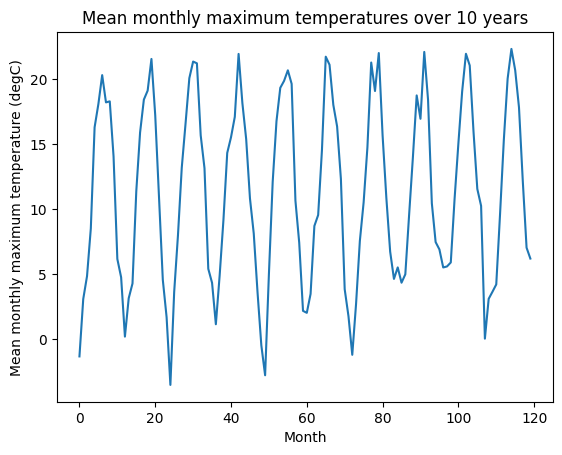

In [4]:
means = np.array(t_max.get_monthly_means())

fig, ax = plt.subplots()
ax.plot(means[:(12*10)])
ax.set_xlabel("Month")
ax.set_ylabel("Mean monthly maximum temperature (degC)")
ax.set_title("Mean monthly maximum temperatures over 10 years")

Text(0.5, 1.0, 'Mean monthly maximum temperatures over 10 years')

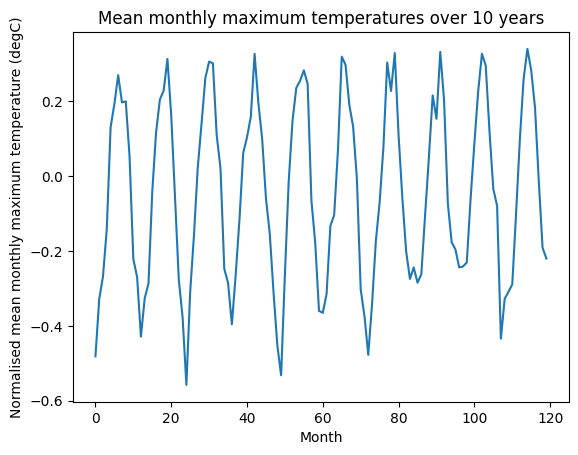

In [5]:
# normalise means: divide by the biggest value
means_normalised = t_max.normalise(means)

fig, ax = plt.subplots()
ax.plot(means_normalised[:(12*10)])
ax.set_xlabel("Month")
ax.set_ylabel("Normalised mean monthly maximum temperature (degC)")
ax.set_title("Mean monthly maximum temperatures over 10 years")

### Train model

In [6]:
WINDOW_SIZE = 12
OFFSET = 12

train_len = int(len(means_normalised) * 0.7)
validate_len = int(len(means_normalised) * 0.2)
test_len = int(len(means_normalised) * 0.1)

# divide data into training, validating and testing sets
means_train = means_normalised[test_len+1:test_len+train_len]
means_validate = means_normalised[test_len+train_len+1:]
means_test = means_normalised[:test_len]

# reshape data into input windows and targets
input_train, target_train = shapeArray(means_train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(means_validate, WINDOW_SIZE, OFFSET)
input_test, target_test = shapeArray(means_test, WINDOW_SIZE, OFFSET)

print(f"Vals shape: {np.shape(vals)}")
print(f"Training input shape: {np.shape(input_train)}")
print(input_train[0:4])
print(f"Training target shape: {np.shape(target_train)}")
print(target_train[0:4])

Vals shape: (47390,)
Training input shape: (1065, 12)
[[-0.3592047  -0.29097282 -0.20187137 -0.00728466  0.11557791  0.21988176
   0.32983878  0.28728805  0.16195072 -0.01497282 -0.18539561 -0.22158151]
 [-0.29097282 -0.20187137 -0.00728466  0.11557791  0.21988176  0.32983878
   0.28728805  0.16195072 -0.01497282 -0.18539561 -0.22158151 -0.34633514]
 [-0.20187137 -0.00728466  0.11557791  0.21988176  0.32983878  0.28728805
   0.16195072 -0.01497282 -0.18539561 -0.22158151 -0.34633514 -0.26549778]
 [-0.00728466  0.11557791  0.21988176  0.32983878  0.28728805  0.16195072
  -0.01497282 -0.18539561 -0.22158151 -0.34633514 -0.26549778 -0.14192934]]
Training target shape: (1065,)
[-0.27723369 -0.26853803 -0.30028039 -0.22958151]


In [7]:
n_features = 1
input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
print(input_train[0])
print(input_test[0])
print(input_validate[0])

[[-0.3592047 ]
 [-0.29097282]
 [-0.20187137]
 [-0.00728466]
 [ 0.11557791]
 [ 0.21988176]
 [ 0.32983878]
 [ 0.28728805]
 [ 0.16195072]
 [-0.01497282]
 [-0.18539561]
 [-0.22158151]]
[[-0.48175543]
 [-0.32849295]
 [-0.26726267]
 [-0.13993833]
 [ 0.13053443]
 [ 0.19277531]
 [ 0.26978081]
 [ 0.19696921]
 [ 0.19973183]
 [ 0.05273733]
 [-0.22149755]
 [-0.27039311]]
[[-3.10887590e-02]
 [-8.60852607e-02]
 [-2.07436585e-01]
 [-2.99610498e-01]
 [-1.70038839e-01]
 [-1.82509049e-01]
 [ 3.91500908e-04]
 [ 1.43983705e-01]
 [ 2.28997198e-01]
 [ 4.52621386e-01]
 [ 4.48331531e-01]
 [ 1.75024185e-01]]


In [8]:
print(input_train[0:4])
print(target_train[0:4])

[[[-0.3592047 ]
  [-0.29097282]
  [-0.20187137]
  [-0.00728466]
  [ 0.11557791]
  [ 0.21988176]
  [ 0.32983878]
  [ 0.28728805]
  [ 0.16195072]
  [-0.01497282]
  [-0.18539561]
  [-0.22158151]]

 [[-0.29097282]
  [-0.20187137]
  [-0.00728466]
  [ 0.11557791]
  [ 0.21988176]
  [ 0.32983878]
  [ 0.28728805]
  [ 0.16195072]
  [-0.01497282]
  [-0.18539561]
  [-0.22158151]
  [-0.34633514]]

 [[-0.20187137]
  [-0.00728466]
  [ 0.11557791]
  [ 0.21988176]
  [ 0.32983878]
  [ 0.28728805]
  [ 0.16195072]
  [-0.01497282]
  [-0.18539561]
  [-0.22158151]
  [-0.34633514]
  [-0.26549778]]

 [[-0.00728466]
  [ 0.11557791]
  [ 0.21988176]
  [ 0.32983878]
  [ 0.28728805]
  [ 0.16195072]
  [-0.01497282]
  [-0.18539561]
  [-0.22158151]
  [-0.34633514]
  [-0.26549778]
  [-0.14192934]]]
[-0.27723369 -0.26853803 -0.30028039 -0.22958151]


In [32]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (WINDOW_SIZE, 1), activation = 'relu', return_sequences = False))
model.add(layers.Dense(1, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 150, validation_data = (input_validate, target_validate))
cost = history.history['loss']

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
34/34 [==============================] - 1s 11ms/step - loss: 0.0516 - val_loss: 0.0380
Epoch 2/150
34/34 [==============================] - 0s 6ms/step - loss: 0.0216 - val_loss: 0.0155
Epoch 3/150
34/34 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 4/150
34/34 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0104
Epoch 5/150
34/34 [==============================

5/5 [==============================] - 0s 4ms/step


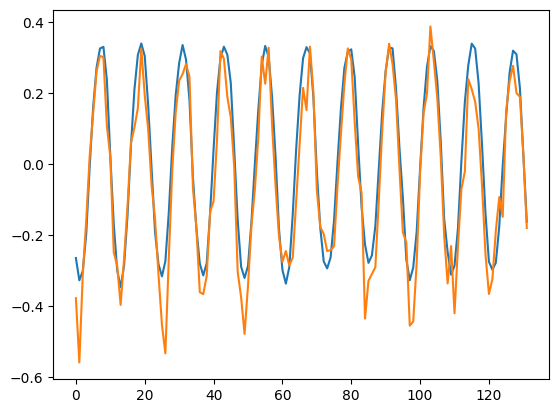

In [33]:
prediction = model.predict(input_test)

fig, ax = plt.subplots()
ax.plot(prediction)
ax.plot(target_test)

In [28]:
print(input_test)

[[[-0.48175543]
  [-0.32849295]
  [-0.26726267]
  ...
  [ 0.05273733]
  [-0.22149755]
  [-0.27039311]]

 [[-0.32849295]
  [-0.26726267]
  [-0.13993833]
  ...
  [-0.22149755]
  [-0.27039311]
  [-0.42888586]]

 [[-0.26726267]
  [-0.13993833]
  [ 0.13053443]
  ...
  [-0.27039311]
  [-0.42888586]
  [-0.32637654]]

 ...

 [[ 0.02096921]
  [-0.20134763]
  [-0.3352047 ]
  ...
  [ 0.21180979]
  [ 0.17644747]
  [ 0.10042149]]

 [[-0.20134763]
  [-0.3352047 ]
  [-0.23004528]
  ...
  [ 0.17644747]
  [ 0.10042149]
  [-0.06158151]]

 [[-0.3352047 ]
  [-0.23004528]
  [-0.41944303]
  ...
  [ 0.10042149]
  [-0.06158151]
  [-0.25316172]]]


In [29]:
print(prediction)

[[0.0000000e+00]
 [1.4873937e-02]
 [8.8186599e-03]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.7762411e-03]
 [2.9195275e-02]
 [7.2717071e-03]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.8789243e-02]
 [8.0991946e-03]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.1866191e-02]
 [3.0026849e-02]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.1002604e-02]
 [9.5658563e-03]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+0

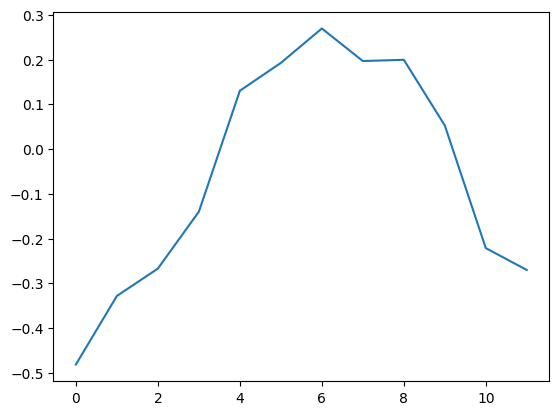

In [30]:
fig, ax = plt.subplots()
ax.plot(input_test[0])


### Plot first 10 years of data against predictions